# **Number of Claims Estimation with Neural Networks (NN)**

Neural Networks are inspired by Neuroscience, they are formed by neurons connected in various ways. They are organized in layers. Neural Networks extend linear models applying a non linear transformation, called activaction function, to the linear combination of weights and input features or latent features coming from preceding layers.

References:

-https://h2oai.github.io/tutorials/introduction-to-machine-learning-with-h2o-3-regression/#0


-["Case Study: French Motor Third-Party Liability Claims"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764), Mario V. Wuthrich, Alexander Noll, Robert Salzmann;

-["Data Analytics for Non-Life Insurance Pricing"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2870308), Mario V. Wuthrich, Christoph Buser;

-["Statistical Foundations of Actuarial Learning and its Applications"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3822407), Mario V. Wuthrich, Michael Merz

# Upload Libraries

In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.2 MB 43 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.1-py2.py3-none-any.whl size=177276478 sha256=e6084c86826f37121219a2320aeb57304b2d66774c7752e2c2f9631a8f59b848
  Stored in directory: /root/.cache/pip/wheels/a1/a1/d9/bb37df368c4635a707e7362d1088450b606041f05aeba5f173
Successfully built h2o


In [ ]:
# handling datasets
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# modelling, evaluation
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import h2o
from h2o.estimators import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Upload File

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving swmotorcycle_ClaimNb.csv to swmotorcycle_ClaimNb.csv


In [ ]:
# Reading File
df = pd.read_csv('swmotorcycle_ClaimNb.csv')

# Data Set Overview

In [ ]:
# Dimensions of data set
print(df.shape)

(64548, 8)


In [ ]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OwnerAge    64548 non-null  int64  
 1   Gender      64548 non-null  object 
 2   Area        64548 non-null  object 
 3   RiskClass   64548 non-null  object 
 4   VehAge      64548 non-null  int64  
 5   BonusClass  64548 non-null  object 
 6   Exposure    64548 non-null  float64
 7   ClaimNb     64548 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.9+ MB
None


In [ ]:
# Take a peek at the first rows of the data
df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0


# Summary Statistics

In [ ]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,64548,2,Male,54695
Area,64548,7,Small towns; countryside except Gotland; North...,24816
RiskClass,64548,7,EV ratio 9-12,18905
BonusClass,64548,7,BM7,17953


In [ ]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df.columns if df[var].dtype!='object']
df[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,64548.0,42.416062,12.980960,0.0,31.000000,44.000000,52.0,92.00000
VehAge,64548.0,12.540063,9.727445,0.0,5.000000,12.000000,16.0,99.00000
Exposure,64548.0,1.010671,1.307424,0.0,0.463014,0.827397,1.0,31.33973
ClaimNb,64548.0,0.010798,0.107323,0.0,0.000000,0.000000,0.0,2.00000


# Data Cleaning

In [ ]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(64548, 8)


In [ ]:
# get number of unique values for each row
counts = df.duplicated()
# record rows to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
print(df.shape)

[]
(64548, 8)


In [ ]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

OwnerAge      0.0
Gender        0.0
Area          0.0
RiskClass     0.0
VehAge        0.0
BonusClass    0.0
Exposure      0.0
ClaimNb       0.0
dtype: float64

In [ ]:
# Feature transformation
df_1 = df.copy()
df_1['Exposure'] = df_1['Exposure'].clip(upper=1)
df_1['VehAge'] = df_1['VehAge'].clip(upper=20)

# Pre-Processing

In [ ]:
# Split dataset
df_train, df_test, = train_test_split(df_1, train_size=0.8, test_size=0.2,random_state=0)

In [ ]:
scaling = MinMaxScaler()
df_train[['VehAge', 'OwnerAge']] = scaling.fit_transform(df_train[['VehAge', 'OwnerAge']])
df_test[['VehAge', 'OwnerAge']] = scaling.fit_transform(df_test[['VehAge', 'OwnerAge']])

In [ ]:
h2o.init(nthreads=-1,max_mem_size = "12G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptl7vw64p
  JVM stdout: /tmp/tmptl7vw64p/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptl7vw64p/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_s6fekx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Convert Pandas data frame into H2O data frame
train = h2o.H2OFrame(df_train)
test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Input 
predictors = ['Gender','RiskClass','Area','BonusClass','OwnerAge','VehAge']
# offset
train["offset"] = train["Exposure"].log()
test["offset"] = test["Exposure"].log()
# Output 
response = 'ClaimNb'

# Modelling 1

In [ ]:
# Define model
NN_model_1 = H2ODeepLearningEstimator(offset_column = "offset", distribution="poisson", reproducible = True, nfolds=5, categorical_encoding='auto', activation="rectifier", hidden=[100],seed=0)

# Train model
NN1 = NN_model_1.train(x=predictors, y=response, training_frame=train)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(NN1)

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1665294185168_1


Status of Neuron Layers: predicting ClaimNb, regression, poisson distribution, Automatic loss, 3,101 weights/biases, 41.3 KB, 464,742 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  --------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        29       Input      0.0
    2        100      Rectifier  0.0        0.0   0.0   0.1462107242182387     0.35404837131500244   0.0         0.0010355852089309462  0.13389205932617188  0.40535667059966696  0.248762309551239
    3        1        Linear                0.0   0.0   0.0019770717626670375  0.00233224313706159

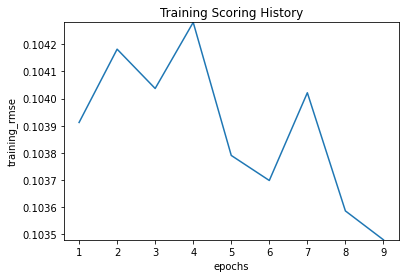

In [ ]:
# plot training history
NN1.plot()

# Model Evaluation 1

In [ ]:
# Eval performance:
perf_train_1 = NN1.model_performance(train)
pred_train_1 = NN1.predict(train)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_1

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.011038970845454002
RMSE: 0.10506650677287221
MAE: 0.021092243503743092
RMSLE: 0.07131663061566174
Mean Residual Deviance: 0.10696678483448958

In [ ]:
# Eval performance:
perf_test_1 = NN1.model_performance(test)
pred_test_1 = NN1.predict(test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_1

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.012692779166572637
RMSE: 0.11266223487297168
MAE: 0.022184420518226382
RMSLE: 0.07596882941167206
Mean Residual Deviance: 0.12205184022656966

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_1 = pred_train_1.as_data_frame()
predictions_te_1 = pred_test_1.as_data_frame()

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_1)

0.0869708859701796

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_1)

0.09985262419680034

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_1))

0.10506650677287248

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_1))

0.1126622348729716

# Modelling 2

In [ ]:
# Input 
predictors_ = ['Gender','RiskClass','Area','OwnerAge','VehAge']

In [ ]:
# Define model
NN_model_2 = H2ODeepLearningEstimator(offset_column = "offset", distribution="poisson", nfolds=5, reproducible=True, categorical_encoding='auto', activation="rectifier", hidden=[100],seed=0)

# Train model
NN2 = NN_model_2.train(x=predictors_, y=response, training_frame=train)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(NN2)

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1665294185168_2


Status of Neuron Layers: predicting ClaimNb, regression, poisson distribution, Automatic loss, 2,301 weights/biases, 31.8 KB, 464,742 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms              momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  --------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        21       Input      0.0
    2        100      Rectifier  0.0        0.0   0.0   0.152950643194795     0.36166512966156006   0.0         -0.0028496797950239333  0.13951927423477173  0.39649780673593393  0.23770660161972046
    3        1        Linear                0.0   0.0   0.002305671264475677  0.0033947583287954

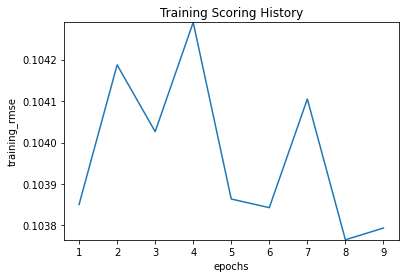

In [ ]:
# plot training history
NN2.plot()

# Model evaluation 2

In [ ]:
# Eval performance:
perf_train_2 = NN2.model_performance(train)
pred_train_2 = NN2.predict(train)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_2

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.011060512445226583
RMSE: 0.10516897092406383
MAE: 0.02133984424590302
RMSLE: 0.07133588982891395
Mean Residual Deviance: 0.10841595518071304

In [ ]:
# Eval performance:
perf_test_2 = NN2.model_performance(test)
pred_test_2 = NN2.predict(test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_2

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.01270959204533681
RMSE: 0.11273682648246229
MAE: 0.022484580140687997
RMSLE: 0.07596910495099321
Mean Residual Deviance: 0.12305075340982312

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_2 = pred_train_2.as_data_frame()
predictions_te_2 = pred_test_2.as_data_frame()

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_2)

0.08842005631640402

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_2)

0.10085153738005367

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_2))

0.10516897092406345

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_2))

0.11273682648246244

# Modelling 3

In [ ]:
# Define model
NN_model_3 = H2ODeepLearningEstimator(offset_column = "offset", distribution="poisson", nfolds=5, reproducible=True, categorical_encoding='auto', activation="rectifier", hidden=[20,100,50],seed=0)

# Train model
NN3 = NN_model_3.train(x=predictors, y=response, training_frame=train)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


In [ ]:
# summary of the model
print(NN3)

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1665294185168_3


Status of Neuron Layers: predicting ClaimNb, regression, poisson distribution, Automatic loss, 7,801 weights/biases, 98.5 KB, 516,380 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms             momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  -------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        29       Input      0.0
    2        20       Rectifier  0.0        0.0   0.0   0.14388614977481132   0.3547581434249878   0.0         0.010530711217331278    0.23398369550704956  0.5768160072546824   0.4714416265487671
    3        100      Rectifier  0.0        0.0   0.0   0.0656290005048504    0.15293312072753906  0

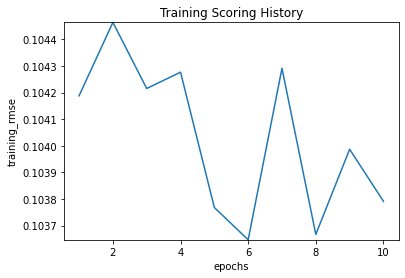

In [ ]:
# plot training history
NN3.plot()

# Model Evaluation 3

In [ ]:
# Eval performance:
perf_train_3 = NN3.model_performance(train)
pred_train_3 = NN3.predict(train)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
perf_train_3

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.011109687276121417
RMSE: 0.10540250128019457
MAE: 0.015143077687306598
RMSLE: 0.07101602320553073
Mean Residual Deviance: 0.11221314719396289

In [ ]:
# Eval performance:
perf_test_3 = NN3.model_performance(test)
pred_test_3 = NN3.predict(test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [ ]:
perf_test_3

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.012741085818026679
RMSE: 0.11287641834336647
MAE: 0.01648584877098102
RMSLE: 0.07561910609772594
Mean Residual Deviance: 0.12932626465756666

In [ ]:
# replace H2O data frame with a pandas data frame
predictions_tr_3 = pred_train_3.as_data_frame()
predictions_te_3 = pred_test_3.as_data_frame()

In [ ]:
mean_poisson_deviance(df_train.ClaimNb,predictions_tr_3)

0.09221724832965357

In [ ]:
mean_poisson_deviance(df_test.ClaimNb,predictions_te_3)

0.10712704862779777

In [ ]:
np.sqrt(mean_squared_error(df_train.ClaimNb, predictions_tr_3))

0.1054025012801946

In [ ]:
np.sqrt(mean_squared_error(df_test.ClaimNb, predictions_te_3))

0.11287641834336669

# **NN Results Analysis**

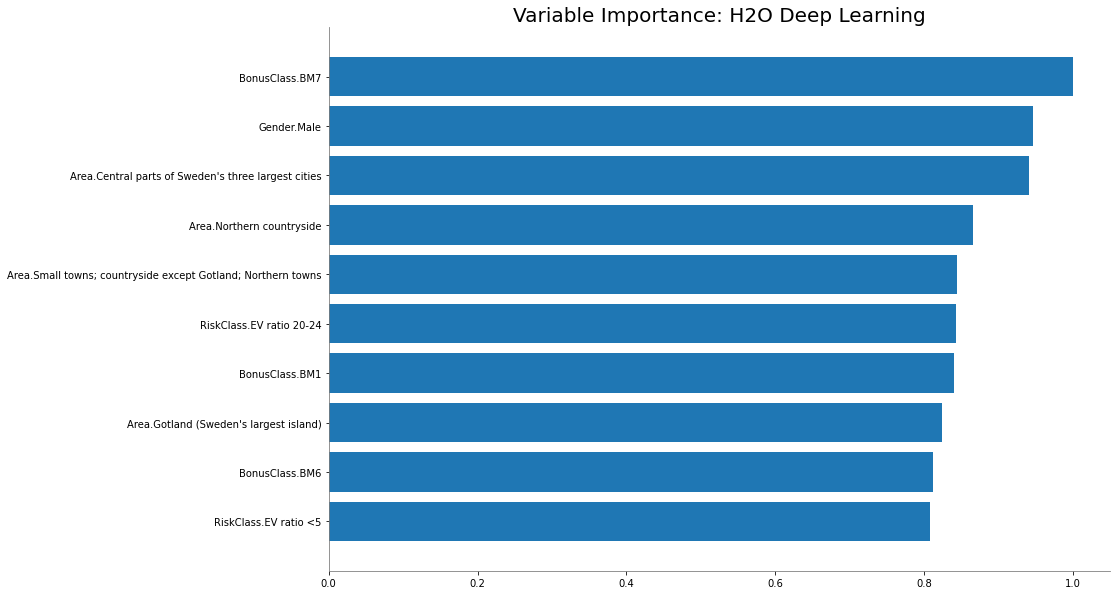

<Figure size 432x288 with 0 Axes>

In [ ]:
# Feature Importance
NN1.varimp_plot()

In [ ]:
predictions_te_1 = predictions_te_1.rename(columns = {'predict':'ClaimNb_pred'})
test = pd.concat([df_test, predictions_te_1.set_index(df_test.index)], axis=1)
test

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimNb_pred
11551,0.280488,Female,Small towns; countryside except Gotland; North...,EV ratio 20-24,0.65,BM3,0.419178,0,0.003248
27696,0.451220,Female,Suburbs; middle-sized cities,EV ratio <5,0.20,BM7,0.983562,0,0.005414
56213,0.634146,Male,Lesser towns except Gotland; Northern towns,EV ratio 13-15,0.80,BM7,1.000000,0,0.003564
8463,0.256098,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,0.65,BM1,0.986301,0,0.020517
35448,0.487805,Male,Small towns; countryside except Gotland; North...,EV ratio 20-24,0.20,BM6,0.986301,0,0.012821
...,...,...,...,...,...,...,...,...,...
15776,0.317073,Female,Lesser towns except Gotland; Northern towns,EV ratio 13-15,0.75,BM7,0.989041,0,0.001513
43435,0.536585,Male,Small towns; countryside except Gotland; North...,EV ratio 13-15,0.55,BM7,1.000000,0,0.007802
50162,0.585366,Male,Suburbs; middle-sized cities,EV ratio 9-12,0.30,BM7,1.000000,0,0.020301
2912,0.207317,Male,Suburbs; middle-sized cities,EV ratio 16-19,0.40,BM1,0.630137,0,0.042292


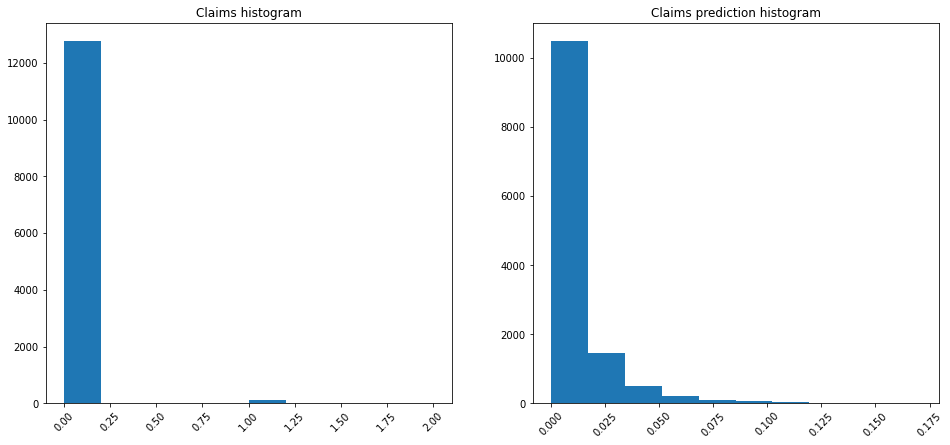

In [ ]:
# Claims comparison
fig = plt.figure(figsize = (16,7))
plt.subplot(1,2,1)  
plt.hist(test['ClaimNb'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims histogram')
plt.subplot(1,2,2)  
plt.hist(test['ClaimNb_pred'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims prediction histogram')
plt.show()

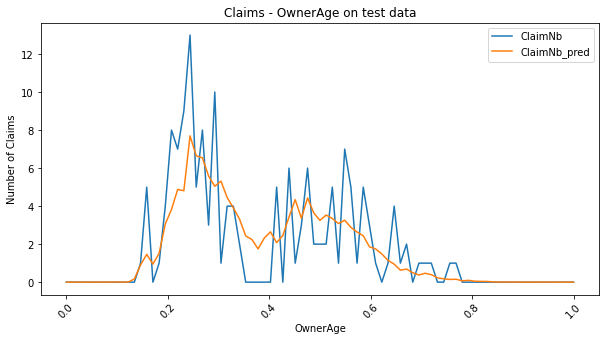

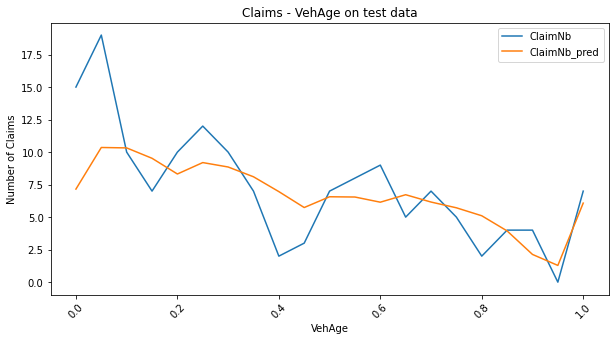

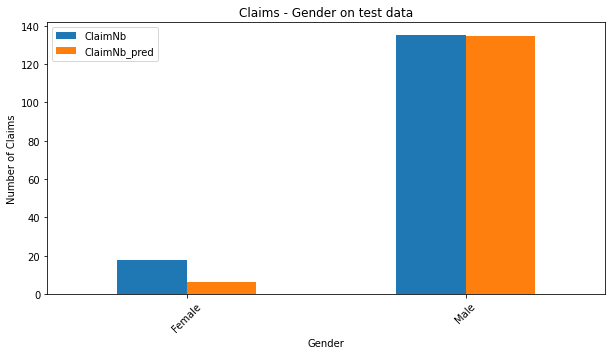

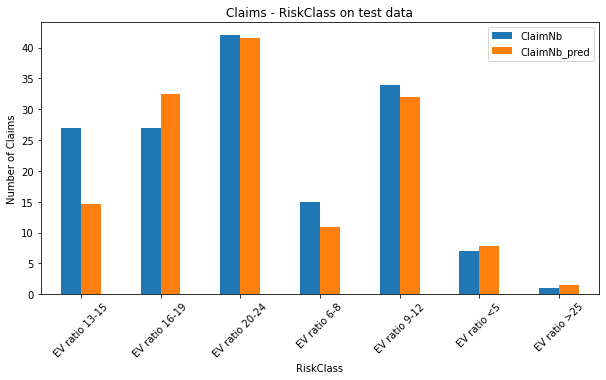

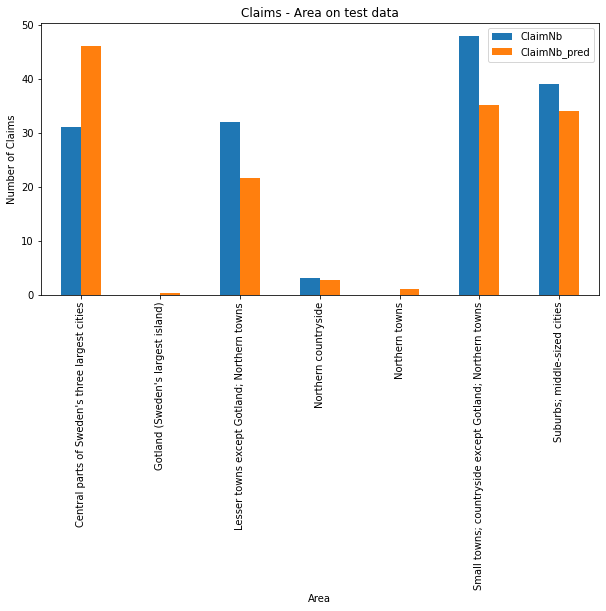

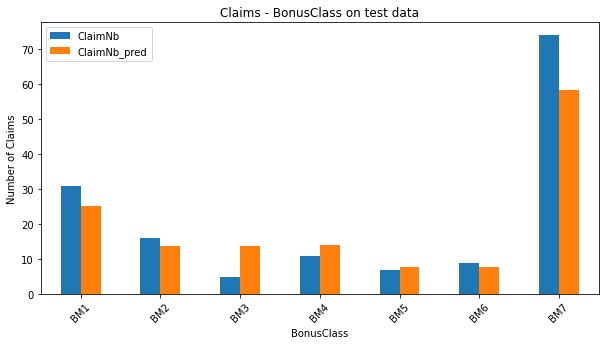

In [ ]:
# Claims and claims predicted comparison on features
plt.rcParams["figure.figsize"] = (10,5)
test_group_oa = test.groupby(['OwnerAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_oa.plot(x='OwnerAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('OwnerAge')
plt.title('Claims - OwnerAge on test data')
plt.show()
test_group_va = test.groupby(['VehAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_va.plot(x='VehAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('VehAge')
plt.title('Claims - VehAge on test data')
plt.show()
test_group_ge = test.groupby(['Gender'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_ge.plot.bar(x='Gender',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('Gender')
plt.title('Claims - Gender on test data')
plt.show()
test_group_rc = test.groupby(['RiskClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_rc.plot.bar(x='RiskClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('RiskClass')
plt.title('Claims - RiskClass on test data')
plt.show()
test_group_a = test.groupby(['Area'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_a.plot.bar(x='Area',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Area')
plt.title('Claims - Area on test data')
plt.show()
test_group_bc = test.groupby(['BonusClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_bc.plot.bar(x='BonusClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('BonusClass')
plt.title('Claims - BonusClass on test data')
plt.show()
